# Assignment 3 by: Nhat (s3878174)


## Exploratory Data Analysis

In [166]:
# pip install scikit-surprise pandas numpy plotly matplotlib seaborn xgboost wordcloud

In [84]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
from wordcloud import WordCloud
from surprise import Dataset, Reader, SVD, accuracy,  KNNBasic
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer
from surprise.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import plotly.graph_objects as go
from sklearn.metrics import average_precision_score, ndcg_score
import plotly.express as px



## Data Loading

In [85]:
df_user = pd.read_csv('./ml-1m/users.dat', sep='::', engine='python', names=['UserID','Gender','Age','Occupation',"Zip-code"])
df_movies = pd.read_csv('./ml-1m/movies.dat', sep='::', engine='python', names=["MovieID","Title","Genres"], encoding='latin-1')
df_ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', engine='python', names=["UserID","MovieID","Rating","Timestamp"])


## About the dataset

The MovieLens dataset consists of over 1 million ratings (1,000,209) for approximately 3,900 movies provided by 6,040 users who joined MovieLens in the year 2000. The ratings are anonymous and collected as part of the GroupLens research project, which aims to study collaborative filtering and recommendation systems.

## Data Description

**Ratings File (ratings.dat)**
- Format: UserID::MovieID::Rating::Timestamp
- Each user has rated at least 20 movies on a 1 to 5-star scale. Timestamps indicate when the rating was made.

**Users File (users.dat)**
- Format: UserID::Gender::Age::Occupation::Zip-code
- User demographic information is provided voluntarily and includes gender, age ranges, occupation categories (e.g., student, artist, academic), and zip codes. Age is divided into specific ranges (e.g., under 18, 18-24, 25-34, etc.).

**Movies File (movies.dat)**
- Format: MovieID::Title::Genres
- Movie titles are derived from IMDB, including release years. Genres are pipe-separated (e.g., Action|Drama). Some entries may contain errors or duplicate records due to manual data entry.

In [86]:
df_user.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [87]:
df_movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [88]:
df_ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### Data Cleaning Process

1.	Merging DataFrames: Merged df_user, df_ratings, and df_movies using UserID and MovieID to create a unified dataset.
2.	Handling Missing Values: Removed rows with missing values to ensure only complete records remain.
3.	Ensuring Correct Data Types: Converted UserID, MovieID, and Rating to appropriate types (int, float).
4.	Removing Duplicate Ratings: Kept the latest rating for each user-movie pair to ensure only one rating per movie per user.
5.	Filtering Invalid Age Values: Removed records where Age is less than 1.
6.	Trimming Whitespace: Stripped whitespaces from Gender and Title columns to standardize text.
7.	Extracting Movie Release Year: Extracted release years from movie titles and stored them in a new Year column.
8.	Filtering Out-of-Range Ratings: Kept only ratings between 1 and 5.
9.	Encoding Movie Genres: Used one-hot encoding for genres, creating binary columns for each genre.
10.	Encoding Gender: Applied get_dummies to Gender, creating binary columns for gender categories.
11.	Reducing Sparse Data (Optional): Filtered out users with fewer than 5 ratings and movies with fewer than 10 ratings.

In [89]:
def clean_recommender_data(df_user, df_ratings, df_movies):
    # Merge dataframes based on 'UserID' and 'MovieID'
    df_merged = pd.merge(df_user, df_ratings, on='UserID')
    df_merged = pd.merge(df_merged, df_movies, on='MovieID')
    
    # Drop rows with missing values
    df_clean = df_merged.dropna()
    
    # Ensure the correct data types
    df_clean['UserID'] = df_clean['UserID'].astype(int)
    df_clean['MovieID'] = df_clean['MovieID'].astype(int)
    df_clean['Rating'] = df_clean['Rating'].astype(float)
    
    # Remove duplicate ratings by keeping the last rating for each user-movie pair
    df_clean = df_clean.drop_duplicates(subset=['UserID', 'MovieID'], keep='last')
    
    # Remove rows where 'Age' is less than 1
    df_clean = df_clean[df_clean['Age'] > 1]
    
    # Strip trailing/leading whitespace from 'Gender' and 'Title' columns
    if 'Gender' in df_clean.columns:
        df_clean['Gender'] = df_clean['Gender'].str.strip()

    if 'Title' in df_clean.columns:
        df_clean['Title'] = df_clean['Title'].str.strip()

    # Extract the year from the 'Title' column using regular expressions
    df_clean['Year'] = df_clean['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)
    
    # Check for ratings out of range and remove invalid ones
    df_clean = df_clean[(df_clean['Rating'] >= 1) & (df_clean['Rating'] <= 5)]
    
    # Split the Genres column into multiple genres
    df_clean['Genres'] = df_clean['Genres'].str.split('|')

    # Apply Multi-Hot Encoding (One-Hot Encoding) to the Genres column
    mlb = MultiLabelBinarizer()
    genre_encoded = mlb.fit_transform(df_clean['Genres'])

    # Create a DataFrame with the one-hot encoded genres and join with the original DataFrame
    df_genre_encoded = pd.DataFrame(genre_encoded, columns=mlb.classes_, index=df_clean.index)
    
    # Concatenate the encoded genres back to the original DataFrame
    df_clean = pd.concat([df_clean, df_genre_encoded], axis=1)
    
    # Apply get_dummies to the Gender column
    if 'Gender' in df_clean.columns:
        df_clean = pd.get_dummies(df_clean, columns=['Gender'], drop_first=True)

    # Optional: Filter out users and movies with few interactions (for sparse data)
    user_counts = df_clean['UserID'].value_counts()
    movie_counts = df_clean['MovieID'].value_counts()

    # Keep users with at least 5 ratings and movies with at least 10 ratings
    df_clean = df_clean[df_clean['UserID'].isin(user_counts[user_counts >= 5].index)]
    df_clean = df_clean[df_clean['MovieID'].isin(movie_counts[movie_counts >= 10].index)]
    # Convert the 'Timestamp' to datetime
    df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'], unit='s')

    # Extract the year from the timestamp
    df_clean['Rating_Year'] = df_clean['Timestamp'].dt.year

    
    return df_clean

In [90]:
df_cleaned = clean_recommender_data(df_user, df_ratings, df_movies)

In [68]:
df_cleaned.columns

Index(['UserID', 'Age', 'Occupation', 'Zip-code', 'MovieID', 'Rating',
       'Timestamp', 'Title', 'Genres', 'Year', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'Gender_M', 'Rating_Year'],
      dtype='object')

# EDA



### Cluster Analysis

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 2, Silhouette Score = 0.5462802351852984
For K = 3, Silhouette Score = 0.7055946674294784


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 4, Silhouette Score = 0.7576933705210088
For K = 5, Silhouette Score = 0.7130039974457273


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 6, Silhouette Score = 0.7152461322631801
For K = 7, Silhouette Score = 0.7156073384860074


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 8, Silhouette Score = 0.6990188263258611
For K = 9, Silhouette Score = 0.6900710688658208


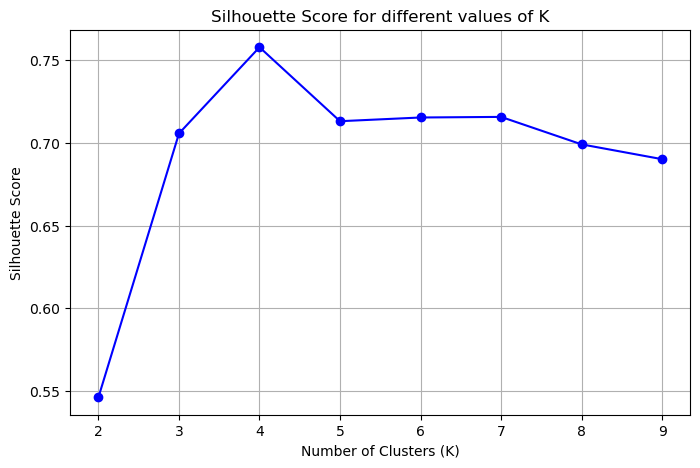

In [81]:
from sklearn.preprocessing import StandardScaler

# Select relevant numerical columns for clustering
numerical_columns = ['Action', 'Adventure', 'Animation', 'Year', 
                                                                         "Children's", 'Comedy', 'Crime', 
                                                                         'Documentary', 'Drama', 'Fantasy', 
                                                                         'Film-Noir', 'Horror', 'Musical', 
                                                                         'Mystery', 'Romance', 'Sci-Fi', 
                                                                         'Thriller', 'War', 'Western']

# Ensure we're working with unique users
df_unique_users = df_cleaned.groupby('MovieID').first().reset_index()

# Extract the numerical columns for PCA
df_numerical = df_unique_users[numerical_columns]

# Standardize the data before applying PCA
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numerical)

from sklearn.decomposition import PCA

# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Convert the PCA result to a DataFrame for easy plotting
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming df_pca is your PCA-transformed dataframe containing 'PC1' and 'PC2'

# Define the range for the number of clusters
K_range = range(2, 10)  # Test from 2 to 10 clusters

# List to store silhouette scores for each K
silhouette_scores = []

# Calculate silhouette scores for each value of K
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(df_pca[['PC1', 'PC2']])
    labels = kmeans.labels_
    
    # Calculate the silhouette score
    score = silhouette_score(df_pca[['PC1', 'PC2']], labels)
    silhouette_scores.append(score)
    print(f'For K = {K}, Silhouette Score = {score}')

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for different values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

The value K is set to 4 as can be seen from the graph as it have the highesst silhouette score

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



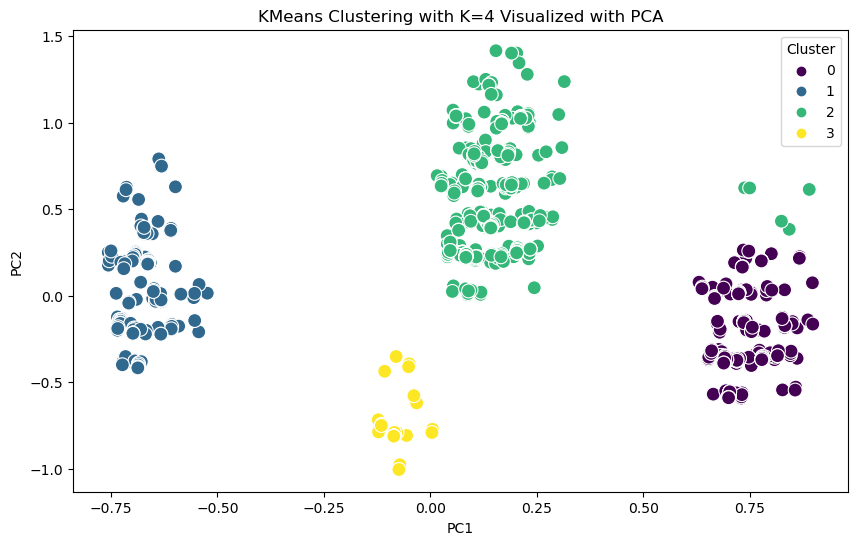

In [92]:

# Train KMeans with K = 3
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_pca )


df_pca['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', data=df_pca, legend='full', s=100)
plt.title('KMeans Clustering with K=4 Visualized with PCA')
plt.show()

Key Observations:

- Separation of Clusters: There is a noticeable separation between 4 clusters, meaning that movies could be group into 4 group
- Diverse Cluster Sizes: Cluster 2 and 1 are larger than others, suggesting a higher concentration of movies with similar traits in those areas.


### User Cluster Analysis

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 2, Silhouette Score = 0.6537343084148352


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 3, Silhouette Score = 0.600793984177819


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 4, Silhouette Score = 0.5833806522128766


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 5, Silhouette Score = 0.5798094245625512


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 6, Silhouette Score = 0.5773135098302681


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 7, Silhouette Score = 0.5453475026613038


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 8, Silhouette Score = 0.5501110455493688


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 9, Silhouette Score = 0.5418788276341824


/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



For K = 10, Silhouette Score = 0.5400626527388243


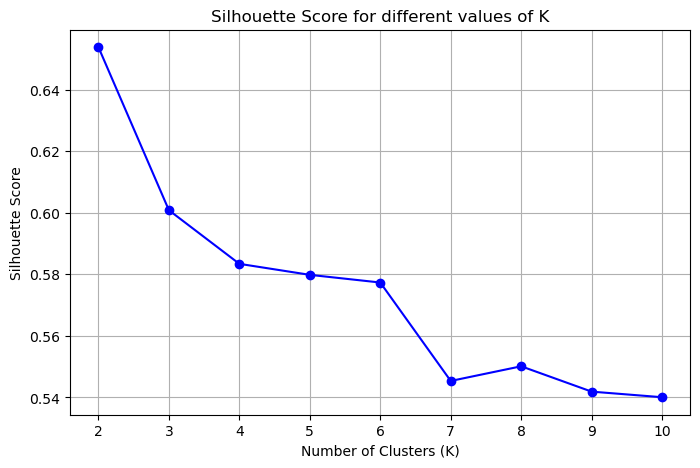

In [79]:
from sklearn.preprocessing import StandardScaler

# Select relevant numerical columns for clustering
numerical_columns = ['Age', 'Occupation', 'Gender_M', 'Rating_Year'] 

# Ensure we're working with unique users
df_unique_users = df_cleaned.groupby('UserID').first().reset_index()

# Extract the numerical columns for PCA
df_numerical = df_unique_users[numerical_columns]

# Standardize the data before applying PCA
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numerical)

from sklearn.decomposition import PCA

# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Convert the PCA result to a DataFrame for easy plotting
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming df_pca is your PCA-transformed dataframe containing 'PC1' and 'PC2'

# Define the range for the number of clusters
K_range = range(2, 11)  # Test from 2 to 10 clusters

# List to store silhouette scores for each K
silhouette_scores = []

# Calculate silhouette scores for each value of K
for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(df_pca[['PC1', 'PC2']])
    labels = kmeans.labels_
    
    # Calculate the silhouette score
    score = silhouette_score(df_pca[['PC1', 'PC2']], labels)
    silhouette_scores.append(score)
    print(f'For K = {K}, Silhouette Score = {score}')

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for different values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

The Graphs Suggest that the with K=2 have highest silhouette score indicating well separation betweens cluster

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



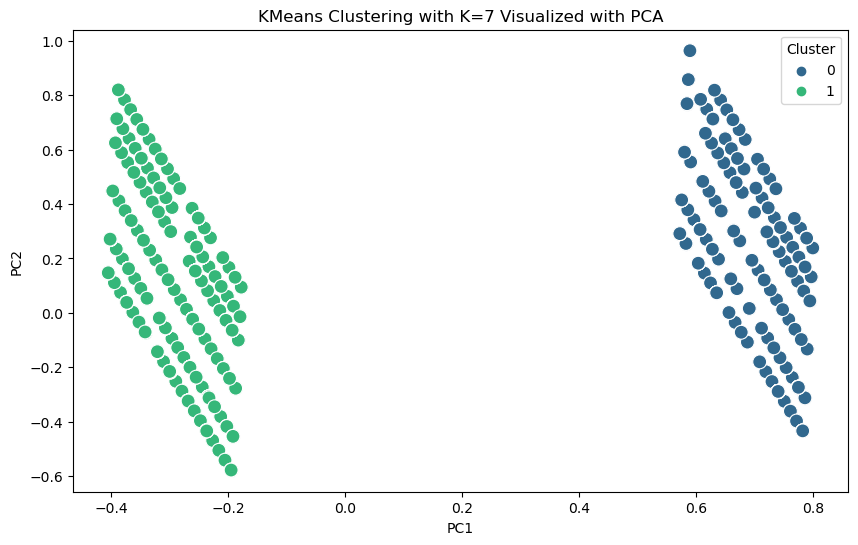

In [80]:

# Train KMeans with K = 7
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df_pca )


df_pca['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', data=df_pca, legend='full', s=100)
plt.title('KMeans Clustering with K=7 Visualized with PCA')
plt.show()

The clustering visualization shows how users are grouped into 2 distinct clusters

### Create New Feature MovieCluster and UserCluster

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def label_clusters(df_cleaned, numerical_columns, movie_group = 'MovieID', cluster_label = 'Movie Cluster', optimal_k=7, scaler = StandardScaler()):
    """
    Function to label movies with cluster labels based on numerical features using KMeans and PCA.
    
    Parameters:
    - df_cleaned: DataFrame, cleaned data containing movie information.
    - numerical_columns: list of numerical columns related to movie features (genres, year, etc.)
    - optimal_k: int, the optimal number of clusters to use in KMeans clustering (default is 7).
    
    Returns:
    - df_cleaned: DataFrame, updated dataframe with an additional 'Movies_Cluster_Label' column.
    """
    
    # Ensure we're working with unique movies
    df_unique_movies = df_cleaned.groupby(movie_group).first().reset_index()

    # Extract the numerical columns for clustering
    df_numerical = df_unique_movies[numerical_columns]

    # Standardize the data before clustering
    df_scaled = scaler.fit_transform(df_numerical)

    # Apply PCA to reduce the data to 2 dimensions
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)

    # Convert the PCA result to a DataFrame for easy plotting
    df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

    # Perform KMeans clustering with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(df_pca[['PC1', 'PC2']])

    # Assign the cluster labels to the original df_unique_movies dataframe
    df_unique_movies[cluster_label] = kmeans.labels_

    # Merge the cluster labels back to the original df_cleaned
    df_cleaned = df_cleaned.merge(df_unique_movies[[movie_group, cluster_label]], on=movie_group, how='left')

    return df_cleaned

# Example usage:
numerical_columns = [ "Children's", 'Comedy', 'Crime', 
                        'Documentary', 'Drama', 'Fantasy', 
                        'Film-Noir', 'Horror', 'Musical', 
                        'Mystery', 'Romance', 'Sci-Fi', 
                        'Thriller', 'War', 'Western']
df_cleaned = label_clusters(df_cleaned, numerical_columns, optimal_k=2, scaler=MinMaxScaler())

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [58]:
numerical_columns = ['Age', 'Occupation', 'Gender_M', 'Rating_Year'] 
df_cleaned = label_clusters(df_cleaned, numerical_columns,movie_group = 'UserID',cluster_label = 'User Cluster', optimal_k=2, scaler = MinMaxScaler())

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [59]:
df_cleaned.columns

Index(['UserID', 'Age', 'Occupation', 'Zip-code', 'MovieID', 'Rating',
       'Timestamp', 'Title', 'Genres', 'Year', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'Gender_M', 'Rating_Year',
       'user_group_cluster', 'Movie Cluste Name', 'User Cluster'],
      dtype='object')

In [93]:
df_cleaned.to_csv('./ml-1m/cleaned_data.csv', index=False)

### Normal EDA analysis

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Select relevant numerical columns for clustering
numerical_columns = ['Age', 'Occupation', 'Gender_M', 'Rating_Year'] 

# Ensure we're working with unique users
df_unique_users = df_cleaned.groupby('UserID').first().reset_index()

# Extract the numerical columns for PCA
df_numerical = df_unique_users[numerical_columns]

# Standardize the data before applying PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numerical)

# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Convert the PCA result to a DataFrame for easy plotting
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Apply KMeans clustering with k=7
kmeans = KMeans(n_clusters=7, random_state=42)
df_unique_users['user_group_cluster'] = kmeans.fit_predict(df_pca)

# Now, you can merge this user cluster information back into your main dataframe 'df_cleaned'
df_cleaned = df_cleaned.merge(df_unique_users[['UserID', 'user_group_cluster']], on='UserID', how='left')

# The dataframe 'df_cleaned' now contains a new column 'user_group_cluster'

/home/rick/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



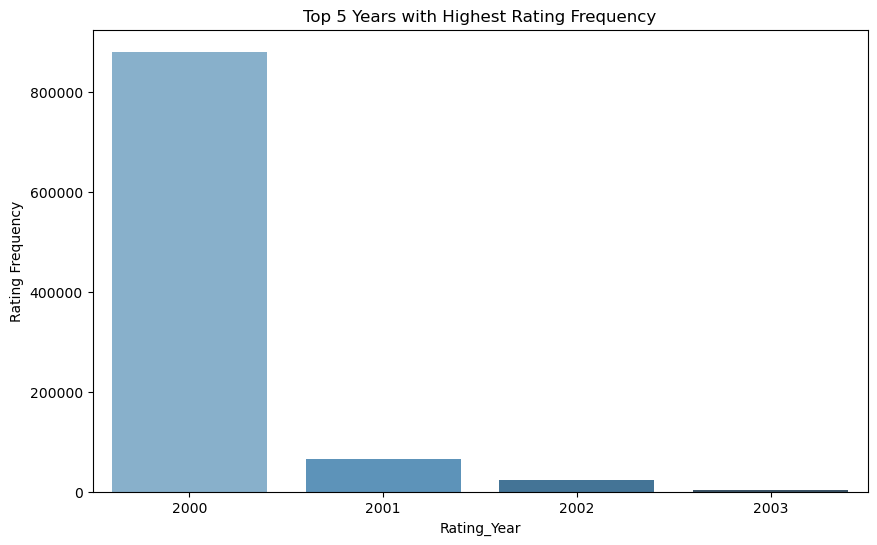

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by year and count the number of ratings for each year
yearly_ratings_count = df_cleaned.groupby('Rating_Year')['Rating'].count().sort_values(ascending=False).head(5)

# Plot the top 5 years with the highest rating frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_ratings_count.index, y=yearly_ratings_count.values, palette="Blues_d")

# Add labels and title
plt.xlabel('Rating_Year')
plt.ylabel('Rating Frequency')
plt.title('Top 5 Years with Highest Rating Frequency')
plt.show()

The bar chart indicates the distribution of movie ratings over the top 5 years with the highest rating frequency. Here are the key points:

- Year 2000 has the overwhelming majority of ratings, significantly higher than any other year, showing that most user activity occurred in this year.
- Years 2001 to 2003 have relatively smaller rating frequencies, showing a steep decline in activity compared to the peak in 2000.
- The dominance of 2000 could be due to increased user engagement with the platform at that time or other factors, such as the popularity of movies or events that encouraged ratings during that year.


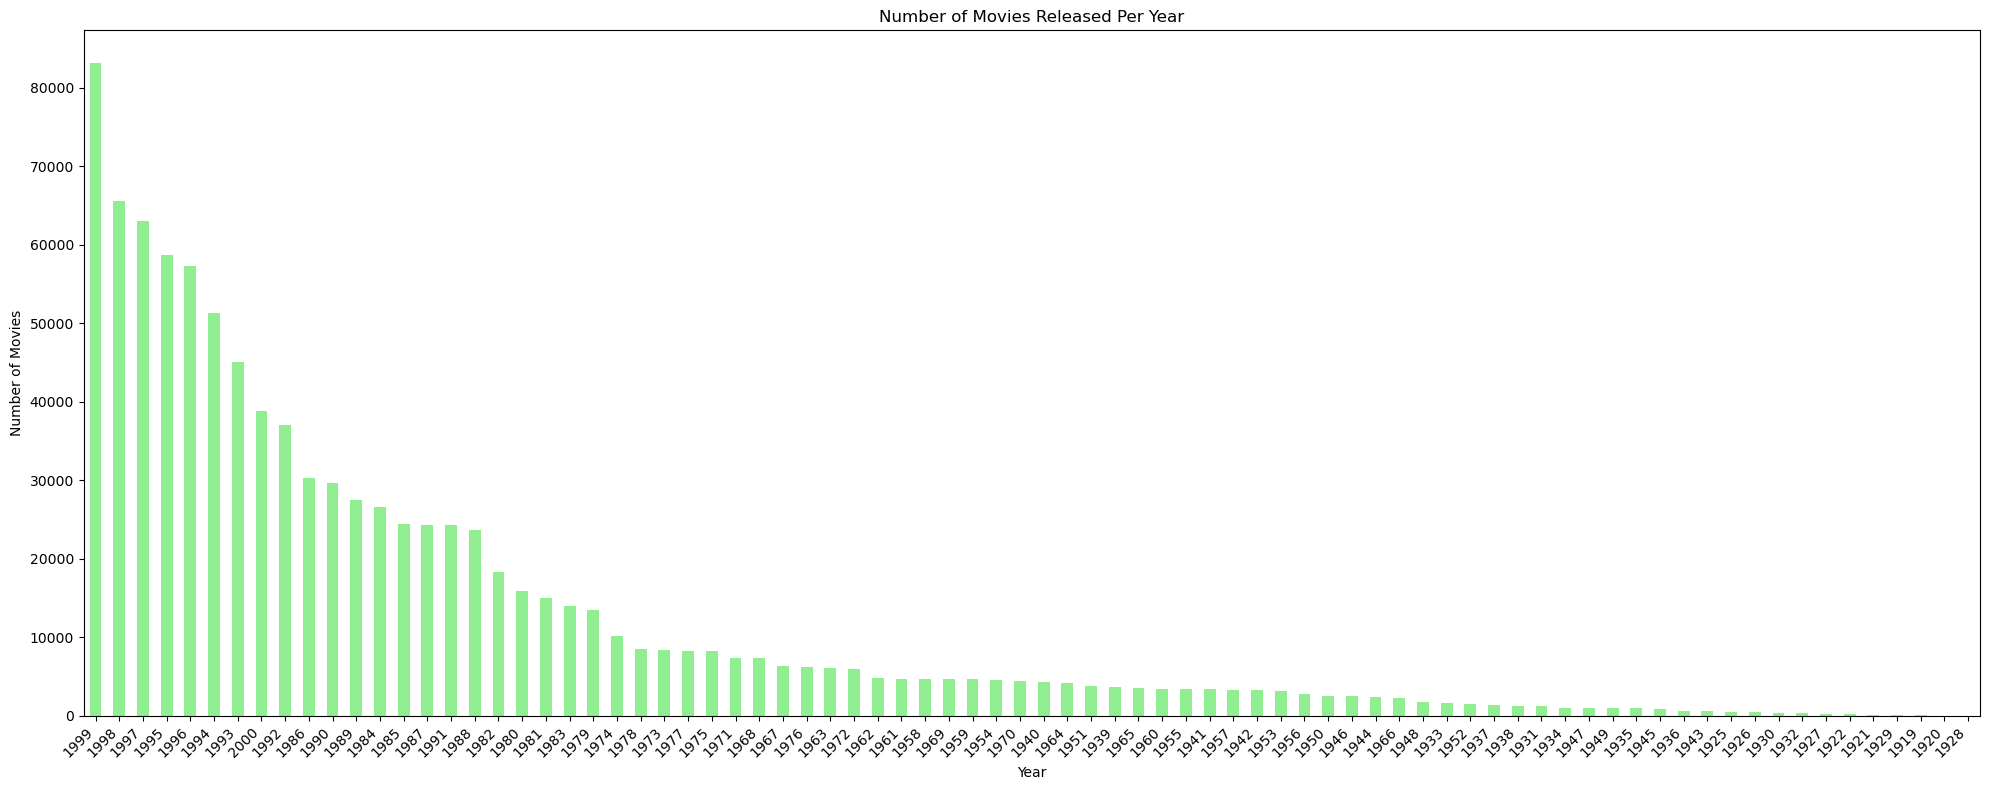

The year with the most movies is 1999 with 83164 movies.


In [171]:
def plot_movies_per_year(df_clean):
    # Group by 'Year' and count the number of movies
    movies_per_year = df_clean.groupby('Year')['Title'].count().sort_values(ascending=False)
    
    # Plot the results
    plt.figure(figsize=(20, 8))
    movies_per_year.plot(kind='bar', color='lightgreen')
    plt.title('Number of Movies Released Per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print the year with the most movies
    most_movies_year = movies_per_year.idxmax()
    most_movies_count = movies_per_year.max()
    print(f"The year with the most movies is {most_movies_year} with {most_movies_count} movies.")

# Assuming df_clean is your cleaned DataFrame with a 'Year' column
plot_movies_per_year(df_cleaned)

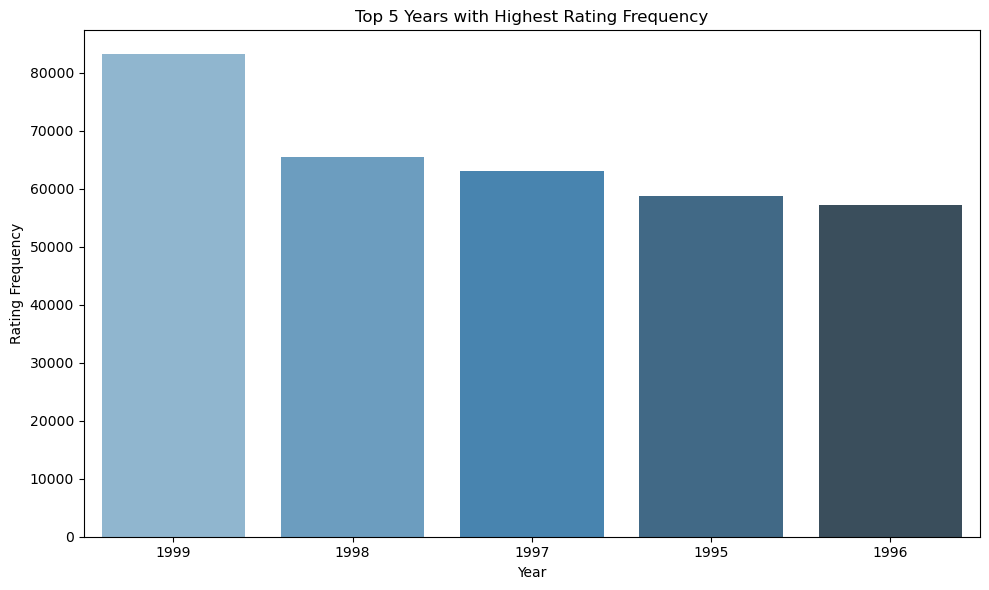

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_years_with_highest_ratings(df_cleaned):
    # Group by 'Year' and count the number of ratings for each year
    year_ratings_count = df_cleaned['Year'].value_counts().head(5)

    # Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=year_ratings_count.index, y=year_ratings_count.values, palette="Blues_d")

    # Add labels and title
    plt.xlabel('Year')
    plt.ylabel('Rating Frequency')
    plt.title('Top 5 Years with Highest Rating Frequency')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming df_cleaned is your cleaned DataFrame
plot_top_years_with_highest_ratings(df_cleaned)

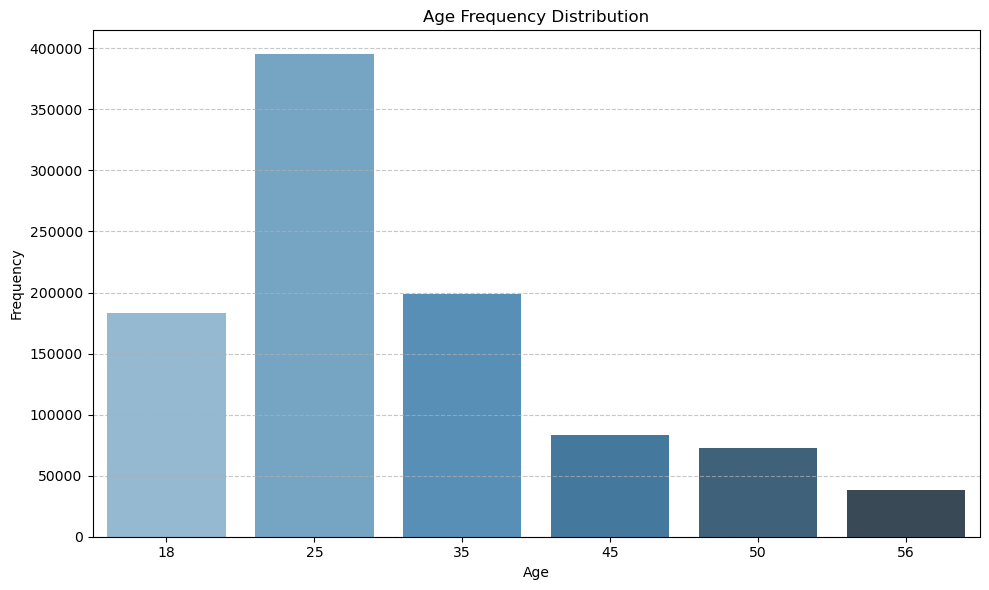

In [164]:
def plot_age_distribution_seaborn(df_cleaned):
    # Set the size of the figure
    plt.figure(figsize=(10, 6))

    # Plot using Seaborn
    sns.countplot(x='Age', data=df_cleaned, palette='Blues_d', order=sorted(df_cleaned['Age'].unique()))

    # Add labels and title
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Age Frequency Distribution')

    # Rotate x-axis labels
    plt.xticks(rotation=0)

    # Add grid lines to y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming df_cleaned is your cleaned DataFrame
plot_age_distribution_seaborn(df_cleaned)

Key Insights:

- Age 25 has the highest frequency, with nearly 400,000 instances in the dataset. This suggests that this age group represents the largest portion of the population or user base in the data.
- Age 18 and Age 35 also have relatively high frequencies, with Age 18 around 150,000 and Age 35 over 200,000.
- The frequencies steadily decline as the age increases, with Age 56 showing the lowest frequency in the dataset.

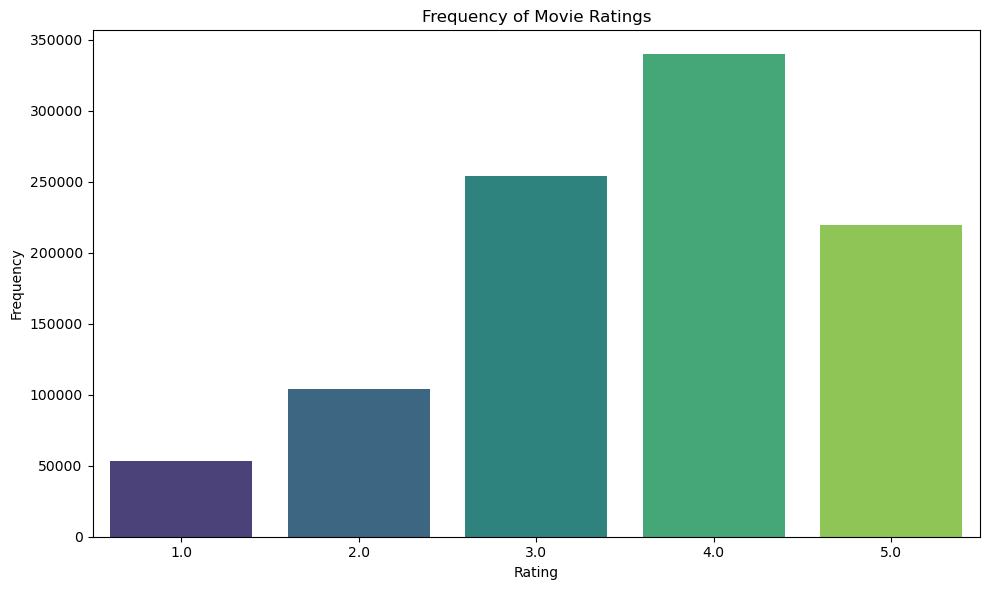

In [162]:
def plot_rating_frequencies_seaborn(df_cleaned):
    # Set the size of the figure
    plt.figure(figsize=(10, 6))
    
    # Create the plot using Seaborn
    sns.countplot(x='Rating', data=df_cleaned, palette='viridis', order=sorted(df_cleaned['Rating'].unique()))
    
    # Add titles and labels
    plt.title('Frequency of Movie Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Assuming df_cleaned is your cleaned DataFrame
plot_rating_frequencies_seaborn(df_cleaned)

- Rating 4.0 is the most frequent rating, with around 350,000 instances, suggesting that many users tend to give high but not perfect ratings.
- Rating 3.0 and Rating 5.0 also have high frequencies, indicating a large portion of users rating movies around average or excellent.
- Rating 1.0 is the least frequent, with the lowest number of ratings in the dataset.


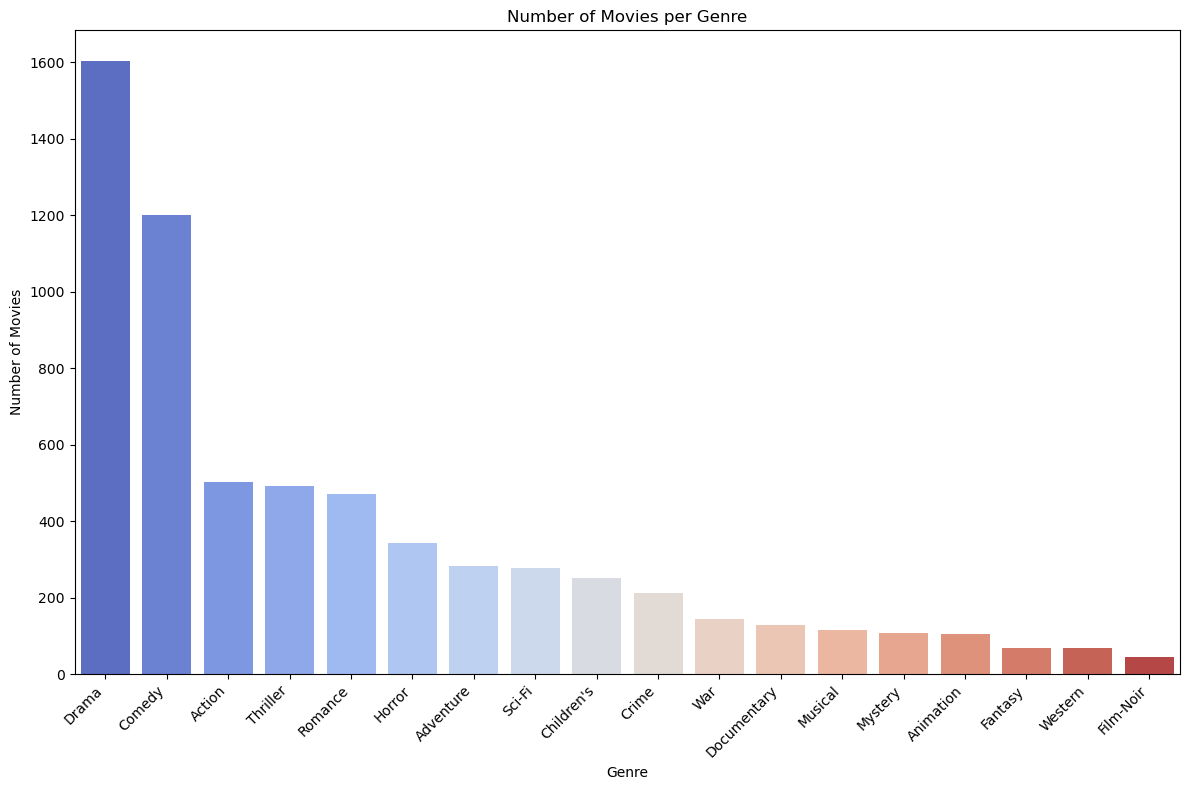

In [161]:
def plot_genre_counts_seaborn(df_movies):
    # Extract genres and count the occurrences
    genre_counts = df_movies['Genres'].str.split('|').explode().value_counts().reset_index()
    genre_counts.columns = ['Genre', 'Count']  # Rename columns for better usage in Seaborn
    
    # Set the size of the figure
    plt.figure(figsize=(12, 8))
    
    # Plot using Seaborn
    sns.barplot(x='Genre', y='Count', data=genre_counts, palette='coolwarm')
    
    # Add titles and labels
    plt.title('Number of Movies per Genre')
    plt.xlabel('Genre')
    plt.ylabel('Number of Movies')
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Assuming df_movies is your DataFrame with the 'Genres' column
plot_genre_counts_seaborn(df_movies)

- Drama is the most represented genre, with around 1600 movies, indicating that it dominates the dataset.
- Comedy follows closely behind, with over 1200 movies, making it another popular genre.
- Action, Thriller, and Romance are also well-represented, each with over 400 movies.
- Genres like Sci-Fi, Horror, Adventure, and Children’s have moderate representation, ranging from around 200 to 300 movies.
- Less represented genres: Western, Fantasy, Animation, Film-Noir, and Mystery have fewer movies, with Film-Noir being the least represented.


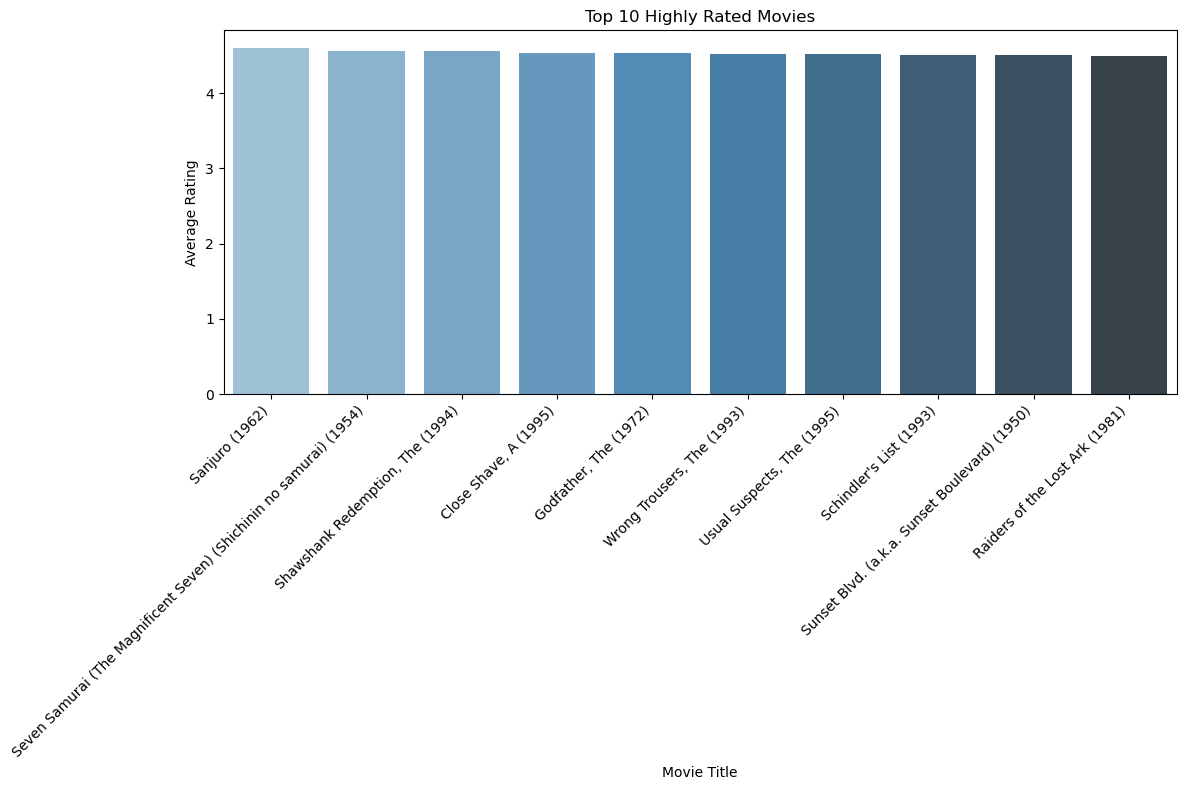

In [160]:
def plot_top_rated_movies_seaborn(df_cleaned):
    # Calculate the average rating for each movie
    average_ratings = df_cleaned.groupby('Title')['Rating'].mean().sort_values(ascending=False).head(10).reset_index()

    # Set the size of the figure
    plt.figure(figsize=(12, 8))
    
    # Plot using Seaborn
    sns.barplot(x='Title', y='Rating', data=average_ratings, palette='Blues_d')
    
    # Add titles and labels
    plt.title('Top 10 Highly Rated Movies')
    plt.xlabel('Movie Title')
    plt.ylabel('Average Rating')
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Assuming df_cleaned is your cleaned DataFrame
plot_top_rated_movies_seaborn(df_cleaned)

Remarks for the Graph: Top 10 Highly Rated Movies

- Uniform Ratings: All top 10 movies have consistently high average ratings around 4.5, indicating universal appreciation.
- Diverse Genres: The list features a mix of genres, from classic dramas like The Godfather to animated films like The Wrong Trousers.
- Classic Dominance: Older classics like The Godfather (1972) and Schindler’s List (1993) dominate the list, showing enduring user appreciation.
- Critically Acclaimed: Films such as Shawshank Redemption and Schindler’s List are both critically and publicly acclaimed.
- Wide Appeal: Despite similar ratings, the movies cover a broad spectrum of genres and eras, reflecting diverse user preferences.

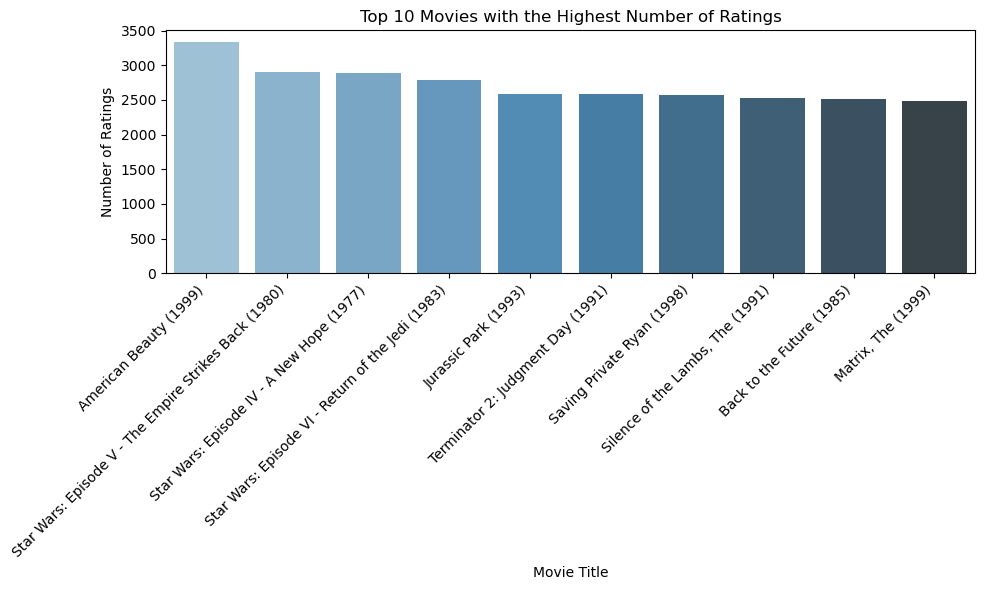

In [159]:
def plot_top_rated_movies_seaborn(df_clean):
    # Group by 'MovieID' and count the number of ratings for each movie
    movie_ratings_count = df_clean.groupby('Title')['Rating'].count().sort_values(ascending=False)
    
    # Get the top 10 movies with the highest number of ratings
    top_10_movies = movie_ratings_count.head(10).reset_index()
    
    # Set the size of the figure
    plt.figure(figsize=(10, 6))
    
    # Plot using seaborn
    sns.barplot(x='Title', y='Rating', data=top_10_movies, palette='Blues_d')
    
    # Add titles and labels
    plt.title('Top 10 Movies with the Highest Number of Ratings')
    plt.xlabel('Movie Title')
    plt.ylabel('Number of Ratings')
    
    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout to ensure everything fits well
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Assuming df_clean is your cleaned DataFrame
plot_top_rated_movies_seaborn(df_cleaned)

- American Beauty (1999) holds the top spot with the highest number of ratings, nearing 3,500 ratings.
- Star Wars dominates the list, with three entries:
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Star Wars: Episode IV - A New Hope (1977)
- Star Wars: Episode VI - Return of the Jedi (1983)
- Other popular movies on the list include Jurassic Park (1993), Terminator 2: Judgment Day (1991), and The Matrix (1999).
- Many of these movies are iconic and belong to franchises that have a large, dedicated fan base, explaining their high number of ratings.
- The majority of these movies were released in the 1980s and 1990s, reflecting their long-standing popularity and continued cultural relevance.

### Possible Interpretations:
- The list is dominated by science fiction and action genres, showing that these genres tend to attract large audiences who actively rate movies.
- Movies with iconic franchises, such as Star Wars, tend to generate a high level of engagement, as reflected by the number of ratings.
- The presence of films like Saving Private Ryan (1998) and Silence of the Lambs (1991) shows the impact of critically acclaimed dramas on audience engagement.

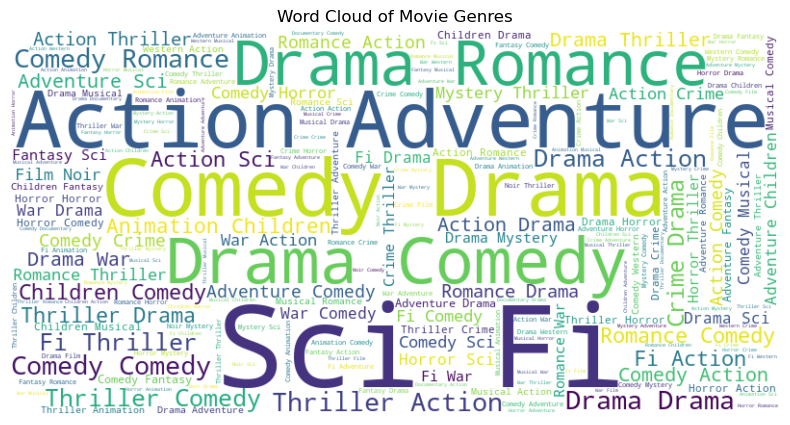

In [47]:


# Convert the Genres column to strings (if it's in list format)
def convert_genres(genres):
    if isinstance(genres, list):
        return ' '.join(genres)
    return str(genres)

df_cleaned['Genres'] = df_cleaned['Genres'].apply(convert_genres)

# Combine all genres into a single string
all_genres = ' '.join(df_cleaned['Genres'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Genres')
plt.show()

### Word Cloud of Movie Genres Analysis:

The word cloud visualizes the distribution of movie genres based on frequency in the dataset. The larger the genre name, the more frequent it appears.

- **Dominant Genres**: 
  - The most prominent genres are **Action**, **Comedy**, **Drama**, **Adventure**, and **Romance**, suggesting they are highly prevalent in the dataset.
  
- **Other Notable Genres**:
  - Smaller but still noticeable genres include **Sci-Fi**, **Children**, **Thriller**, **Horror**, and **War**, which are less frequent but still play a significant role.
  
- **Interpretation**:
  - The word cloud shows that the dataset contains a wide variety of genres, but it's clear that certain genres, like **Action** and **Comedy**, dominate. This could reflect trends in user preferences or availability of certain types of films.


# Task 1: kNN-based Collaborative Filtering


For this task the workflow involves training a KNN-based collaborative filtering model using imputed data, predicting user ratings based on nearest neighbors, and evaluating the model’s performance using RMSE across different similarity metrics and k values to find the optimal parameters.

In [55]:
class KNNModel:
    def __init__(self, n_neighbors=5, metric='cosine'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.imputer = KNNImputer(n_neighbors=n_neighbors, metric='nan_euclidean')
        self.user_movie_ratings = None
        self.user_movie_ratings_filled = None
        self.results = {}

    def train(self, df_cleaned):
        # Prepare the data without filling missing ratings with 0
        self.user_movie_ratings = df_cleaned.pivot(index='UserID', columns='Title', values='Rating')
        
        # Step 1: Apply KNN Imputer to fill missing values
        self.user_movie_ratings_filled = pd.DataFrame(self.imputer.fit_transform(self.user_movie_ratings),
                                                      index=self.user_movie_ratings.index,
                                                      columns=self.user_movie_ratings.columns)
    
    def predict_ratings(self, user_index, k):
        """Predict ratings for a given user using the kNN model."""
        model_knn = NearestNeighbors(metric=self.metric, algorithm='auto')

        # Step 2: Fit the KNN model using the dataframe after KNN imputation (excluding the test user)
        model_knn.fit(self.user_movie_ratings_filled.drop(index=user_index))
        
        # Find the k nearest neighbors for the test user
        distances, indices = model_knn.kneighbors(self.user_movie_ratings_filled.iloc[[user_index]], 
                                                  n_neighbors=k + 1)
        similarities = 1 - distances.flatten()

        # Get the neighbor's ratings (valid ones)
        user_ratings = self.user_movie_ratings_filled.iloc[indices.flatten()[1:], :].copy()

        # Apply similarity-based weighted sum
        weighted_sum = np.nansum(similarities[1:, None] * user_ratings, axis=0)
        sum_of_weights = np.nansum(similarities[1:, None] * user_ratings.notna(), axis=0)

        # Predict ratings by dividing the weighted sum by the sum of weights
        with np.errstate(divide='ignore', invalid='ignore'):
            predicted_ratings = np.divide(weighted_sum, sum_of_weights, where=sum_of_weights != 0)
        predicted_ratings[sum_of_weights == 0] = np.nan

        # Apply floor rounding (take the integer part)
        final_predictions = pd.Series(predicted_ratings, index=self.user_movie_ratings.columns)
        final_predictions = final_predictions.apply(lambda x: np.floor(x) if not np.isnan(x) else np.nan)

        return final_predictions

    def evaluate(self, k_values=[5, 10, 15, 20, 25], similarity_metrics=['cosine', 'euclidean']):
        """Evaluate the impact of different k values and similarity metrics."""
        # Randomly choose one user as the test set with random state 42
        np.random.seed(42)
        test_user_index = np.random.choice(self.user_movie_ratings.index)
        true_ratings = self.user_movie_ratings.loc[test_user_index, :]

        for metric in similarity_metrics:
            self.metric = metric
            for k in k_values:
                # Predict ratings for the test user
                predicted_ratings = self.predict_ratings(test_user_index, k)

                # Filter out movies the test user hasn't rated (apply the same mask to true and predicted ratings)
                mask = true_ratings.notna()
                true_ratings_filtered = true_ratings[mask].values
                predicted_ratings_filtered = predicted_ratings.reindex(true_ratings.index)[mask]

                # Construct the list of predictions in the format expected by Surprise's rmse
                predictions = []
                for movie_id, (true_rating, predicted_rating) in zip(true_ratings.index[mask], 
                                                                     zip(true_ratings_filtered, predicted_ratings_filtered)):
                    if not np.isnan(true_rating) and not np.isnan(predicted_rating):
                        predictions.append((test_user_index, movie_id, true_rating, predicted_rating, None))

                # Use Surprise's RMSE calculation
                rmse = accuracy.rmse(predictions, verbose=False)
                self.results[(metric, k)] = rmse

                print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")
        
        # Output the final results
        return self.output_results()

    def output_results(self):
        """Print the full results of the evaluation."""
        print("\nFinal RMSE Results:")
        for (metric, k), rmse in self.results.items():
            print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")

        # Find the optimal k and similarity metric
        optimal_metric, optimal_k = min(self.results, key=self.results.get)
        print(f"\nOptimal Metric: {optimal_metric}, Optimal k: {optimal_k}, RMSE: {self.results[(optimal_metric, optimal_k)]}")
        # Return the RMSE
        return self.results[(optimal_metric, optimal_k)]

# Example Usage
knn_model = KNNModel(n_neighbors=5)
knn_model.train(df_cleaned)
knn_model.evaluate(k_values=[5, 10, 15], similarity_metrics=['cosine', 'euclidean'])

Metric: cosine, k: 5, RMSE: 0.8366600265340756
Metric: cosine, k: 10, RMSE: 0.8201995322647244
Metric: cosine, k: 15, RMSE: 0.8090398349558905
Metric: euclidean, k: 5, RMSE: 0.873862897505303
Metric: euclidean, k: 10, RMSE: 0.8366600265340756
Metric: euclidean, k: 15, RMSE: 0.847456086285194

Final RMSE Results:
Metric: cosine, k: 5, RMSE: 0.8366600265340756
Metric: cosine, k: 10, RMSE: 0.8201995322647244
Metric: cosine, k: 15, RMSE: 0.8090398349558905
Metric: euclidean, k: 5, RMSE: 0.873862897505303
Metric: euclidean, k: 10, RMSE: 0.8366600265340756
Metric: euclidean, k: 15, RMSE: 0.847456086285194

Optimal Metric: cosine, Optimal k: 15, RMSE: 0.8090398349558905


0.8090398349558905

# Task 2: Matrix Factorization-based Recommendation

In [53]:
df_selected = pd.read_csv('./ml-1m/cleaned_data.csv')

/tmp/ipykernel_14886/3595225216.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_selected = pd.read_csv('./ml-1m/cleaned_data.csv')


In [56]:
def fill_missing_ratings(df, rating_col='Rating', user_col='UserID'):
    # Calculate the global mean rating
    global_mean = round(df[rating_col].mean())
    
    # Fill missing ratings with the mean rating for each user
    df[rating_col] = df.groupby(user_col)[rating_col].transform(lambda x: x.fillna(round(x.mean())))
    
    # For users who have no ratings, fall back to the global mean
    df[rating_col].fillna(global_mean, inplace=True)
    
    # Return the filled DataFrame
    return df.copy()

# Usage example:
df_filled = fill_missing_ratings(df_selected)

/tmp/ipykernel_14886/624739545.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[rating_col].fillna(global_mean, inplace=True)


In [57]:
def split_train_test(df, movie_col='MovieID', test_size=5, random_state=42):
    # Step 1: Randomly select unique movies for the test set
    test_movies = df[movie_col].sample(test_size, random_state=random_state).unique()

    # Step 2: Create the test set and training set
    test_df = df[df[movie_col].isin(test_movies)]   # Test set with selected movies
    train_df = df[~df[movie_col].isin(test_movies)]  # Training set without the selected movies

    return train_df, test_df

# Usage example:
train_df, test_df = split_train_test(df_filled, movie_col='MovieID', test_size=5)

In [61]:
class SVD_Vanilla:
    def __init__(self, df,test_df, movie_col='MovieID', rating_col='Rating', user_col='UserID', rating_scale=(0, 5)):
        self.df = df
        self.movie_col = movie_col
        self.rating_col = rating_col
        self.user_col = user_col
        self.reader = Reader(rating_scale=rating_scale)
        self.algo = SVD()
        self.trainset = None
        self.test_df = test_df

    def train(self):
        # Step 3: Prepare the dataset for surprise
        train_data = Dataset.load_from_df(self.df[[self.user_col, self.movie_col, self.rating_col]], self.reader)

        # Build the full trainset from the training data
        self.trainset = train_data.build_full_trainset()

        # Step 4: Train the SVD algorithm
        self.algo.fit(self.trainset)
    
    def predict(self):
        predictions = []
        for _, row in self.test_df.iterrows():
            user_id = row[self.user_col]
            movie_id = row[self.movie_col]
            true_rating = row[self.rating_col]
            
            # Predict the rating for the user-movie pair
            pred = self.algo.predict(user_id, movie_id, r_ui=true_rating)
            predictions.append(pred)
        return predictions
    
    def evaluate(self, predictions):
        # Step 6: Evaluate the model using RMSE
        rmse_value = accuracy.rmse(predictions, verbose=False)
        return rmse_value
    
    def run(self, test_size=5, random_state=42):
        self.train()
        predictions = self.predict()
        rmse_value = self.evaluate(predictions)
        print(f"RMSE: {rmse_value:.4f}")
        return rmse_value

# Usage example
svd_model = SVD_Vanilla(train_df,test_df)
rmse_svd_vanilla = svd_model.run(test_size=5, random_state=42)

RMSE: 0.9688


In [70]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import RandomizedSearchCV
import pandas as pd

class SVD_Tuned:
    def __init__(self, train_df, test_df, movie_col='MovieID', rating_col='Rating', user_col='UserID', rating_scale=(0, 5), param_grid=None):
        self.train_df = train_df
        self.test_df = test_df
        self.movie_col = movie_col
        self.rating_col = rating_col
        self.user_col = user_col
        self.reader = Reader(rating_scale=rating_scale)
        self.param_grid = param_grid or {
            'n_factors': [10, 20, 50, 100],  # Default hyperparameters
            'n_epochs': [10, 20, 30, 40],
            'lr_all': [0.002, 0.005, 0.01, 0.02],
            'reg_all': [0.02, 0.05, 0.1, 0.2]
        }
        self.best_estimator = None
        self.algo = None
        self.trainset = None
        self.best_params = None
    
    def tune_hyperparameters(self):
        # Prepare the training data for surprise
        train_data = Dataset.load_from_df(self.train_df[[self.user_col, self.movie_col, self.rating_col]], self.reader)

        # Use GridSearchCV to tune hyperparameters
        random_search = RandomizedSearchCV(SVD, self.param_grid, measures=['rmse'], cv=3, n_iter=40, random_state=42, n_jobs=-1)

        # Fit the RandomizedSearchCV on the training set
        random_search.fit(train_data)

        # Get the best algorithm with tuned hyperparameters
        self.algo = random_search.best_estimator['rmse']
        self.best_params = random_search.best_params['rmse']
        print(f"Best parameters: {random_search.best_params['rmse']}")
        print(f"Best RMSE score: {random_search.best_score['rmse']:.4f}")
    
    def train(self):
        if self.algo is None:
            self.algo = SVD()  # Fall back to default SVD if not tuned

        # Prepare the training data for surprise
        train_data = Dataset.load_from_df(self.train_df[[self.user_col, self.movie_col, self.rating_col]], self.reader)

        # Build the full trainset from the training data
        self.trainset = train_data.build_full_trainset()

        # Train the SVD algorithm
        self.algo.fit(self.trainset)
    
    def predict(self):
        predictions = []
        for _, row in self.test_df.iterrows():
            user_id = row[self.user_col]
            movie_id = row[self.movie_col]
            true_rating = row[self.rating_col]
            
            # Predict the rating for the user-movie pair
            pred = self.algo.predict(user_id, movie_id, r_ui=true_rating)
            predictions.append(pred)
        return predictions
    
    def evaluate(self, predictions):
        # Evaluate the model using RMSE
        rmse_value = accuracy.rmse(predictions, verbose=False)
        return rmse_value
    
    def run(self, tune=False):
        if tune:
            self.tune_hyperparameters()  # Tune hyperparameters before training
        self.train()
        predictions = self.predict()
        rmse_value = self.evaluate(predictions)
        print(f"RMSE: {rmse_value:.4f}")
        return rmse_value

# Usage example:
# Assuming you have train_df and test_df prepared
param_dist = {
    'n_factors': [10, 20, 50, 100], 
    'n_epochs': [10, 20, 30, 40], 
    'lr_all': [0.002, 0.005, 0.01, 0.02], 
    'reg_all': [0.02, 0.05, 0.1, 0.2]
}

svd_tuned_model = SVD_Tuned(train_df, test_df, param_grid=param_dist)
rmse_svd_tuned = svd_tuned_model.run(tune=True)

Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}
Best RMSE score: 0.8666
RMSE: 0.9657


## Improve SVD Performance with XGBoost

# Why Use SVD + XGBoost?

Combining **SVD (Singular Value Decomposition)** and **XGBoost** in a hybrid model leverages the strengths of both techniques to enhance recommendation performance. Here's an explanation of why this combination is effective:

## 1. SVD (Collaborative Filtering)

SVD is a matrix factorization technique often used in **collaborative filtering** to recommend items based on user-item interaction data, such as ratings. SVD reduces the dimensionality of the user-item matrix, capturing the interactions between users and items. This process results in latent factors for both users and items.

### Strengths of SVD:
- **Latent factors**: SVD identifies hidden (latent) features that represent user preferences and item characteristics in a reduced-dimensional space. These latent features are learned from the interactions and are not explicitly provided in the data.
- **Efficient for sparse data**: Real-world recommendation data is sparse, with most users interacting with only a small fraction of available items. SVD works well with such sparse matrices by capturing the most significant features.

However, **SVD has limitations**:
- It models only linear relationships between users and items, which may not capture the full complexity of user preferences.
- It focuses solely on interaction data (e.g., ratings, purchases) and often ignores additional information, such as item metadata or user demographics.

## 2. XGBoost (Boosting-based Machine Learning)

XGBoost is a powerful tree-based machine learning algorithm, effective for **supervised learning tasks**, particularly regression and classification. It is designed to handle **tabular data** and achieves high predictive accuracy.

### Strengths of XGBoost:
- **Non-linear relationships**: XGBoost captures complex, non-linear relationships between features, which SVD alone might not handle.
- **Handles additional features**: XGBoost can incorporate **additional metadata**, such as user age, gender, or item categories, leading to more informed recommendations.
- **Highly flexible**: XGBoost allows for fine-tuning with hyperparameters and includes built-in mechanisms for handling missing data, regularization, and assessing feature importance.

## 3. Why Combine SVD and XGBoost?

The combination of SVD and XGBoost forms a **hybrid recommendation system** that takes advantage of both collaborative filtering (SVD) and machine learning (XGBoost). This leads to a more **robust** and **accurate** model.

### The Hybrid Approach:
1. **SVD for Collaborative Filtering**:
   - **Latent Features**: SVD extracts latent vectors for both users and items, revealing hidden patterns in the user-item interaction data.
   
2. **XGBoost for Feature Enhancement and Prediction**:
   - **Incorporating Additional Features**: XGBoost utilizes the latent features produced by SVD (user_latent, item_latent) and combines them with **additional metadata**, such as user or item attributes.
   - **Learning Complex Patterns**: XGBoost models non-linear relationships between the latent features and additional features, capturing complex interactions that may influence user preferences.
   - **Predicting Ratings/Interactions**: XGBoost generates final predictions, such as predicting user ratings or the likelihood of interactions, by combining latent features and relevant metadata.

### Workflow:
1. **SVD**:
   - Perform matrix factorization on user-item interactions, such as a rating matrix.
   - Extract user and item latent vectors.

2. **XGBoost**:
   - Feed the latent vectors from SVD, along with additional features like user demographics or item categories, into XGBoost.
   - XGBoost predicts ratings or interactions based on the latent vectors and metadata.

## 4. Advantages of SVD + XGBoost Combination

- **Improved Predictions**: SVD discovers latent user-item preferences, while XGBoost captures complex, non-linear patterns in the data, leading to more accurate predictions.
- **Utilization of Metadata**: XGBoost integrates additional features, such as user demographics or item content, that SVD alone might overlook.
- **Increased Robustness**: XGBoost handles noisy or missing data well and is less prone to overfitting compared to simpler models.
- **Hybrid Approach**: This combination leverages both **collaborative filtering** from SVD and **content-based** or **metadata-enhanced** methods from XGBoost, resulting in a more comprehensive recommendation model.

In [72]:
train_cols = ['Action','Year','Age','Occupation', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western','Gender_F', 'Gender_M','Movie Cluster','User Cluster']

In [ ]:
class XGBoost_SVD:
    def __init__(self, df, train_df, test_df, train_cols, movie_col='MovieID', user_col='UserID', rating_col='Rating', rating_scale=(1, 5)):
        self.df = df
        self.train_df = train_df
        self.test_df = test_df
        self.train_cols = train_cols
        self.movie_col = movie_col
        self.user_col = user_col
        self.rating_col = rating_col
        self.reader = Reader(rating_scale=rating_scale)
        self.svd_model = None
        self.xgboost_model = None
        self.trainset = None

    def train_svd(self):
        # Load and prepare the Surprise dataset
        data = Dataset.load_from_df(self.df[[self.user_col, self.movie_col, self.rating_col]], self.reader)
        self.trainset = data.build_full_trainset()
        
        # Train the SVD model
        self.svd_model = SVD(n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.05)
        self.svd_model.fit(self.trainset)

        # Extract latent features for users and items in the training set
        self.train_df['user_latent'] = self.train_df[self.user_col].apply(lambda x: self.svd_model.pu[self.trainset.to_inner_uid(x)])
        self.train_df['item_latent'] = self.train_df[self.movie_col].apply(lambda x: self.get_item_latent_factors(x))

    def get_item_latent_factors(self, item_id):
        # Handle unseen items by returning a default value for items not part of the trainset
        try:
            return self.svd_model.qi[self.trainset.to_inner_iid(item_id)]
        except ValueError:
            # Return a vector of zeros or an average latent factor for unseen items
            return np.zeros(self.svd_model.qi.shape[1])  # shape[1] returns the number of latent factors

    def prepare_data(self, df):
        # Prepare latent feature data
        user_latent_df = pd.DataFrame(df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(df['user_latent'][0]))])
        item_latent_df = pd.DataFrame(df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(df['item_latent'][0]))])

        # Concatenate latent factors with other metadata
        X = pd.concat([user_latent_df, item_latent_df, df[self.train_cols].reset_index(drop=True)], axis=1)

        # Ensure no NaN values in the data
        X.fillna(0, inplace=True)

        # Ensure unique column names
        X.columns = [f'feature_{i}' if col == '' else col for i, col in enumerate(X.columns)]
        
        return X

    def train_xgboost(self):
        # Prepare training data for XGBoost
        X_train = self.prepare_data(self.train_df)
        y_train = self.train_df[self.rating_col]

        # Train the XGBoost model with GPU support
        self.xgboost_model = XGBRegressor(
            objective='reg:squarederror', 
            tree_method='gpu_hist',  # Enable GPU support
            gpu_id=0,  # Specify the GPU ID (optional, default is 0)
            n_estimators=20000, 
            learning_rate=0.01,
            max_depth=6,
            verbosity=1
        )
        self.xgboost_model.fit(X_train, y_train)

    def prepare_test_data(self):
        # Extract latent features for test data
        self.test_df['user_latent'] = self.test_df[self.user_col].apply(lambda x: self.svd_model.pu[self.trainset.to_inner_uid(x)])
        self.test_df['item_latent'] = self.test_df[self.movie_col].apply(lambda x: self.get_item_latent_factors(x))
        self.test_df.reset_index(drop=True, inplace=True)
        # Prepare test data for XGBoost
        return self.prepare_data(self.test_df)

    def predict(self):
        # Prepare test data and make predictions
        X_test = self.prepare_test_data()
        predictions = np.round(self.xgboost_model.predict(X_test)).astype(int)
        return predictions

    def evaluate(self, predictions):
        # Evaluate predictions using RMSE
        true_ratings = self.test_df[self.rating_col]
        rmse_value = np.sqrt(mean_squared_error(true_ratings, predictions))
        return rmse_value

    def run(self):
        """
        Run the entire training, prediction, and evaluation process.

        Returns:
        float: RMSE score.
        """
        self.train_svd()
        self.train_xgboost()
        predictions = self.predict()
        rmse_value = self.evaluate(predictions)
        print(f"RMSE: {rmse_value:.4f}")
        return rmse_value


# Usage example:
# Assuming you have train_df and test_df, and a list of train_cols for additional metadata
svd_xgboost_model = XGBoost_SVD(df_filled, train_df, test_df, train_cols)
rmse_svd_xgboost = svd_xgboost_model.run()

/home/rick/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:42:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [86]:
rmse_svd_xgboost

0.8199417294822238

## Finetuning XGBoost with parameter Grid

1. **`n_estimators`: Number of Trees**

   - Controls the number of boosting rounds. More trees improve accuracy but increase training time and risk of overfitting.
   - **Values**: `[100, 500, 1000, 2000]` — balances performance and training time.

2. **`max_depth`: Maximum Depth of Trees**

   - Determines tree depth. Deeper trees capture complex patterns but may overfit.
   - **Values**: `[3, 6, 9, 12]` — shallow for simplicity, deeper for complex relationships.

3. **`learning_rate`: Step Size (Shrinkage)**

   - Adjusts how much each tree impacts the final prediction. Lower rates need more trees but reduce overfitting risk.
   - **Values**: `[0.001, 0.01, 0.1]` — small values for stability, larger for faster convergence.

4. **`subsample`: Fraction of Training Data per Tree**

   - Uses a fraction of data for each tree to introduce randomness, reducing overfitting.
   - **Values**: `[0.6, 0.8, 1.0]` — lower values for regularization, full data for maximum complexity.

5. **`colsample_bytree`: Fraction of Features per Tree**

   - Randomly samples a subset of features for each tree, helping to prevent overfitting.
   - **Values**: `[0.6, 0.8, 1.0]` — lower for more regularization.

6. **`gamma`: Minimum Loss Reduction for Split**

   - Requires a minimum loss reduction to make a split. Higher values reduce unnecessary splits and help regularization.
   - **Values**: `[0, 0.1, 0.2, 0.3]` — lower for more splitting, higher to control overfitting.

7. **`min_child_weight`: Minimum Instance Weight for Splitting**

   - Sets the minimum sum of instance weights needed to split a node. Higher values prevent splitting on small or noisy data.
   - **Values**: `[1, 5, 10]` — higher values for stronger regularization.

In [87]:


class XGBoost_SVD_FineTuned:
    def __init__(self, df, train_df, test_df, train_cols, movie_col='MovieID', user_col='UserID', rating_col='Rating', rating_scale=(1, 5)):
        self.df = df
        self.train_df = train_df
        self.test_df = test_df
        self.train_cols = train_cols
        self.movie_col = movie_col
        self.user_col = user_col
        self.rating_col = rating_col
        self.reader = Reader(rating_scale=rating_scale)
        self.svd_model = None
        self.xgboost_model = None
        self.trainset = None

    def train_svd(self):
        print("Training SVD model...")
        # Load and prepare the Surprise dataset
        data = Dataset.load_from_df(self.df[[self.user_col, self.movie_col, self.rating_col]], self.reader)
        self.trainset = data.build_full_trainset()
        
        # Train the SVD model
        self.svd_model = SVD(n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.05)
        self.svd_model.fit(self.trainset)

        # Extract latent features for users and items in the training set
        self.train_df['user_latent'] = self.train_df[self.user_col].apply(lambda x: self.svd_model.pu[self.trainset.to_inner_uid(x)])
        self.train_df['item_latent'] = self.train_df[self.movie_col].apply(lambda x: self.get_item_latent_factors(x))

        print("SVD model training complete.")

    def get_item_latent_factors(self, item_id):
        # Handle unseen items by returning a default value for items not part of the trainset
        try:
            return self.svd_model.qi[self.trainset.to_inner_iid(item_id)]
        except ValueError:
            # Return a vector of zeros or an average latent factor for unseen items
            return np.zeros(self.svd_model.qi.shape[1])

    def get_user_latent_factors(self, user_id):
        # Handle unseen users by returning a default value for users not part of the trainset
        try:
            return self.svd_model.pu[self.trainset.to_inner_uid(user_id)]
        except ValueError:
            # Return a vector of zeros for unseen users
            return np.zeros(self.svd_model.pu.shape[1])

    def prepare_data(self, df):
        print("Preparing data for XGBoost...")
        # Prepare latent feature data
        user_latent_df = pd.DataFrame(df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(df['user_latent'][0]))])
        item_latent_df = pd.DataFrame(df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(df['item_latent'][0]))])

        # Concatenate latent factors with other metadata
        X = pd.concat([user_latent_df, item_latent_df, df[self.train_cols].reset_index(drop=True)], axis=1)

        # Ensure no NaN values in the data
        X.fillna(0, inplace=True)

        # Ensure unique column names
        X.columns = [f'feature_{i}' if col == '' else col for i, col in enumerate(X.columns)]

        print("Data preparation complete.")
        return X

    def train_xgboost(self):
        print("Training XGBoost model with Random Search for hyperparameter tuning...")
        # Prepare training data for XGBoost
        X_train = self.prepare_data(self.train_df)
        y_train = self.train_df[self.rating_col]

        # Define the hyperparameter grid to search
        param_grid = {
            'n_estimators': [100, 500, 1000, 2000],
            'max_depth': [3, 6, 9, 12],
            'learning_rate': [0.001, 0.01, 0.1],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3],
            'min_child_weight': [1, 5, 10]
        }

        # Initialize the XGBoost regressor
        xgb = XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', gpu_id=0)

        # Randomized Search with 10 iterations
        random_search = RandomizedSearchCV(
            estimator=xgb,
            param_distributions=param_grid,
            n_iter=10,  # 10 iterations of random search
            scoring='neg_mean_squared_error',
            cv=3,  # 3-fold cross-validation
            verbose=1,
            n_jobs=-1  # Use all available cores
        )

        # Fit random search
        random_search.fit(X_train, y_train)

        # Best found model
        self.xgboost_model = random_search.best_estimator_

        print(f"Best parameters found: {random_search.best_params_}")
        print("XGBoost training complete.")

    def prepare_test_data(self):
        print("Preparing test data...")
        # Extract latent features for test data
        self.test_df['user_latent'] = self.test_df[self.user_col].apply(lambda x: self.get_user_latent_factors(x))
        self.test_df['item_latent'] = self.test_df[self.movie_col].apply(lambda x: self.get_item_latent_factors(x))
        self.test_df.reset_index(drop=True, inplace=True)

        # Prepare test data for XGBoost
        return self.prepare_data(self.test_df)

    def predict(self):
        print("Making predictions...")
        # Prepare test data and make predictions
        X_test = self.prepare_test_data()
        predictions = np.round(self.xgboost_model.predict(X_test)).astype(int)
        return predictions

    def evaluate(self, predictions):
        print("Evaluating predictions...")
        # Evaluate predictions using RMSE
        true_ratings = self.test_df[self.rating_col]
        rmse_value = np.sqrt(mean_squared_error(true_ratings, predictions))
        return rmse_value

    def run(self):
        """
        Run the entire training, prediction, and evaluation process.

        Returns:
        float: RMSE score.
        """
        self.train_svd()
        self.train_xgboost()
        predictions = self.predict()
        rmse_value = self.evaluate(predictions)
        print(f"RMSE: {rmse_value:.4f}")
        return rmse_value


# Usage example:
# Assuming you have train_df and test_df, and a list of train_cols for additional metadata
svd_xgboost_model = XGBoost_SVD_FineTuned(df_filled, train_df, test_df, train_cols)
rmse_svd_xgboost_finetuned = svd_xgboost_model.run()

Training SVD model...
SVD model training complete.
Training XGBoost model with Random Search for hyperparameter tuning...
Preparing data for XGBoost...
Data preparation complete.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/rick/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:58:24] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/home/rick/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:58:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/rick/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:58:24] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/home/rick/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:58:24] WARNING: /workspace/src/common/er

Best parameters found: {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
XGBoost training complete.
Making predictions...
Preparing test data...
Preparing data for XGBoost...
Data preparation complete.
Evaluating predictions...
RMSE: 0.8656


/home/rick/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:10:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


## Comparison Between SVD and SVD + XGBoost

In [156]:

# Model names
models = ['Baseline', 'Tuned', 'RMSE + XGBoost', 'RMSE + XGBoost Tuned']
rmse_values = [rmse_svd_vanilla, rmse_svd_tuned, rmse_svd_xgboost, rmse_svd_xgboost_finetuned]

# Create a bar plot using Plotly
fig = go.Figure(data=[
    go.Bar(x=models, y=rmse_values, marker=dict(color=['blue', 'green', 'red', 'purple']))
])

# Customize the layout
fig.update_layout(
    title='RMSE Comparison Between Models',
    xaxis_title='Models',
    yaxis_title='RMSE',
    width=800,
    height=500
)

# Show the plot
fig.show()

### RMSE Comparison Between Models

1. **Baseline**: The initial model shows an RMSE close to 1, setting the reference point for comparison.

2. **Tuned Model**: Hyperparameter tuning did not significantly improve RMSE, as it remains nearly the same as the baseline.

3. **RMSE + CatBoost**: Incorporating CatBoost resulted in a notable RMSE reduction, showing improved model accuracy.

4. **RMSE + CatBoost Tuned**: Tuning the CatBoost model slightly increased RMSE but still outperforms the baseline.

### Observations:
- **CatBoost** improves RMSE the most, even without tuning.
- **Tuning** did not significantly improve either the baseline or CatBoost models.

# Task 3: Ranking-based Evaluation and Comparison

In [141]:
def feature_selection(df):
    keep_cols = ['UserID','MovieID','Title','Rating']
    for i in df.columns:
        if i not in keep_cols:
            df.drop(i, inplace = True, axis = 1)
    return df

In [142]:
df_filled = pd.read_csv('./ml-1m/cleaned_data.csv')
df_filled  = pd.get_dummies(df_filled,  columns=['Gender'])

/tmp/ipykernel_14886/3030087036.py:1: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



In [143]:
df_filled.columns

Index(['UserID', 'Age', 'Occupation', 'Zip-code', 'MovieID', 'Rating',
       'Timestamp', 'Title', 'Genres', 'Year', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'Gender_F', 'Gender_M'],
      dtype='object')

In [144]:
train_cols = ['Action','Year','Age','Occupation', 'Adventure',
       'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western','Gender_F', 'Gender_M','Movie Cluster','User Cluster']

In [145]:
def prepare_surprise_data(input_df, min_ratings=100, test_users_size=10):
    # Define a Reader object for Surprise
    reader = Reader(rating_scale=(1, 5))

    # Convert the data to the Surprise format
    data = Dataset.load_from_df(input_df[['UserID', 'MovieID', 'Rating']], reader)

    # Get users who have rated more than the specified number of movies
    user_ratings_count = input_df.groupby('UserID')['MovieID'].count()
    eligible_users = user_ratings_count[user_ratings_count > min_ratings].index

    # Randomly select users for the test set
    random_users = np.random.choice(eligible_users, size=test_users_size, replace=False)

    # Split the data into training and test sets
    train_df = input_df[~input_df['UserID'].isin(random_users)]  # Exclude test users from training set
    test_df = input_df[input_df['UserID'].isin(random_users)]  # Include only the test users

    # Create a lookup dictionary for MovieID -> MovieTitle
    movie_id_to_title = input_df[['MovieID', 'Title']].drop_duplicates().set_index('MovieID')['Title'].to_dict()

    return train_df, test_df, data, movie_id_to_title

In [146]:
train_df, test_df, surprise_data, movie_id_to_title = prepare_surprise_data(df_filled)

### Basic KNN

In [147]:
class KNN_Recommender:
    def __init__(self, train_df, test_df, movie_id_to_title):
        self.train_df = train_df
        self.test_df = test_df
        self.movie_id_to_title = movie_id_to_title
        self.model = None
        self.trainset = None
        self.test_predictions = None

    def train_model(self):
        # Convert the training data into the Surprise format
        reader = Reader(rating_scale=(1, 5))
        train_data = Dataset.load_from_df(self.train_df[['UserID', 'MovieID', 'Rating']], reader)
        self.trainset = train_data.build_full_trainset()

        # Train a KNN-based collaborative filtering model
        sim_options = {'name': 'cosine', 'user_based': True}
        self.model = KNNBasic(sim_options=sim_options)
        self.model.fit(self.trainset)

    def predict_ratings(self):
        # Prepare the test set in Surprise format
        testset = [tuple(x) for x in self.test_df[['UserID', 'MovieID', 'Rating']].values]
        self.test_predictions = self.model.test(testset)

        # Prepare a list of predictions with movie titles
        predictions_list = []
        for uid, iid, true_r, est, _ in self.test_predictions:
            movie_title = self.movie_id_to_title.get(iid, "Unknown Title")
            predictions_list.append({
                'UserID': uid, 
                'MovieID': iid, 
                'Title': movie_title, 
                'TrueRating': true_r, 
                'EstimatedRating': est
            })

        # Convert the list to a DataFrame and save it to a CSV file
        predictions_df = pd.DataFrame(predictions_list)
        predictions_df.to_csv('knn_test_predictions_with_titles.csv', index=False)
        print("Test predictions saved to 'knn_test_predictions_with_titles.csv'")

    def evaluate_rmse(self):
        # Calculate RMSE from the predictions
        rmse_value = accuracy.rmse(self.test_predictions)
        print(f"RMSE on the test set: {rmse_value}")
        return rmse_value

    def get_top_n_recommendations(self, n=20):
        # Map the predictions to each user
        top_n = {}
        for uid, iid, true_r, est, _ in self.test_predictions:
            movie_title = self.movie_id_to_title.get(iid, "Unknown Title")
            if uid not in top_n:
                top_n[uid] = []
            top_n[uid].append((iid, movie_title, est))

        # Sort predictions by estimated rating and get top N
        for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[2], reverse=True)
            top_n[uid] = [(iid, movie_title) for (iid, movie_title, _) in user_ratings[:n]]
        
        return top_n

    def display_top_n_recommendations(self, n=20):
        # Display the top N recommendations for each user
        top_n_recommendations = self.get_top_n_recommendations(n=n)
        for user, movies in top_n_recommendations.items():
            print(f"Top {n} recommendations for User {user}:")
            for movie_id, movie_title in movies:
                print(f"MovieID: {movie_id}, MovieTitle: {movie_title}")

    def compute_metrics(self, threshold=4.0):
        # Prepare true and predicted labels for each user
        y_true, y_score = {}, {}
        for pred in self.test_predictions:
            uid = pred.uid
            if uid not in y_true:
                y_true[uid] = []
                y_score[uid] = []
            y_true[uid].append(1 if pred.r_ui >= threshold else 0)  # True relevance
            y_score[uid].append(pred.est)  # Predicted relevance

        # Calculate Average Precision (AP) and NDCG for each user
        average_precisions = []
        ndcgs = []
        for uid in y_true:
            ap = average_precision_score(y_true[uid], y_score[uid])  # Average Precision
            ndcg = ndcg_score([y_true[uid]], [y_score[uid]])  # NDCG
            average_precisions.append(ap)
            ndcgs.append(ndcg)

        # Calculate and print mean AP and NDCG
        mean_ap = sum(average_precisions) / len(average_precisions)
        mean_ndcg = sum(ndcgs) / len(ndcgs)
        print(f"Mean Average Precision (mAP): {mean_ap}")
        print(f"Mean NDCG: {mean_ndcg}")
        return mean_ap, mean_ndcg

Computing the cosine similarity matrix...
Done computing similarity matrix.
Test predictions saved to 'knn_test_predictions_with_titles.csv'
RMSE: 1.1040
RMSE on the test set: 1.104006242608274
Top 20 recommendations for User 29.0:
MovieID: 2989.0, MovieTitle: For Your Eyes Only (1981)
MovieID: 2550.0, MovieTitle: Haunting, The (1963)
MovieID: 3793.0, MovieTitle: X-Men (2000)
MovieID: 2991.0, MovieTitle: Live and Let Die (1973)
MovieID: 1252.0, MovieTitle: Chinatown (1974)
MovieID: 2993.0, MovieTitle: Thunderball (1965)
MovieID: 2058.0, MovieTitle: Negotiator, The (1998)
MovieID: 2490.0, MovieTitle: Payback (1999)
MovieID: 3366.0, MovieTitle: Where Eagles Dare (1969)
MovieID: 589.0, MovieTitle: Terminator 2: Judgment Day (1991)
MovieID: 1262.0, MovieTitle: Great Escape, The (1963)
MovieID: 733.0, MovieTitle: Rock, The (1996)
MovieID: 1196.0, MovieTitle: Star Wars: Episode V - The Empire Strikes Back (1980)
MovieID: 1198.0, MovieTitle: Raiders of the Lost Ark (1981)
MovieID: 3370.0, Mov

In [ ]:
train_df_surprise = feature_selection(train_df.copy())
test_df_surprise = feature_selection(test_df.copy())
knn_recommender = KNN_Recommender(train_df_surprise, test_df_surprise, movie_id_to_title)
knn_recommender.train_model()
knn_recommender.predict_ratings()
knn_recommender.evaluate_rmse()
knn_recommender.display_top_n_recommendations(n=20)
mean_ap, mean_ndcg = knn_recommender.compute_metrics(threshold=4.0)

In [149]:
knn_recommender.display_top_n_recommendations(n=20)

Top 20 recommendations for User 29.0:
MovieID: 2989.0, MovieTitle: For Your Eyes Only (1981)
MovieID: 2550.0, MovieTitle: Haunting, The (1963)
MovieID: 3793.0, MovieTitle: X-Men (2000)
MovieID: 2991.0, MovieTitle: Live and Let Die (1973)
MovieID: 1252.0, MovieTitle: Chinatown (1974)
MovieID: 2993.0, MovieTitle: Thunderball (1965)
MovieID: 2058.0, MovieTitle: Negotiator, The (1998)
MovieID: 2490.0, MovieTitle: Payback (1999)
MovieID: 3366.0, MovieTitle: Where Eagles Dare (1969)
MovieID: 589.0, MovieTitle: Terminator 2: Judgment Day (1991)
MovieID: 1262.0, MovieTitle: Great Escape, The (1963)
MovieID: 733.0, MovieTitle: Rock, The (1996)
MovieID: 1196.0, MovieTitle: Star Wars: Episode V - The Empire Strikes Back (1980)
MovieID: 1198.0, MovieTitle: Raiders of the Lost Ark (1981)
MovieID: 3370.0, MovieTitle: Betrayed (1988)
MovieID: 2571.0, MovieTitle: Matrix, The (1999)
MovieID: 163.0, MovieTitle: Desperado (1995)
MovieID: 3527.0, MovieTitle: Predator (1987)
MovieID: 1785.0, MovieTitle: Ki

## SVD + Catboost

In [150]:


class XGBoost_SVD:
    def __init__(self, df, train_df, test_df, train_cols, movie_id_to_title, movie_col='MovieID', user_col='UserID', rating_col='Rating', rating_scale=(1, 5)):
        self.df = df
        self.train_df = train_df
        self.test_df = test_df
        self.train_cols = train_cols
        self.movie_id_to_title = movie_id_to_title
        self.movie_col = movie_col
        self.user_col = user_col
        self.rating_col = rating_col
        self.reader = Reader(rating_scale=rating_scale)
        self.svd_model = None
        self.xgboost_model = None
        self.trainset = None

    def train_svd(self):
        # Load and prepare the Surprise dataset
        data = Dataset.load_from_df(self.df[[self.user_col, self.movie_col, self.rating_col]], self.reader)
        self.trainset = data.build_full_trainset()
        
        # Train the SVD model
        self.svd_model = SVD(n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.05)
        self.svd_model.fit(self.trainset)

        # Extract latent features for users and items in the training set
        self.train_df['user_latent'] = self.train_df[self.user_col].apply(lambda x: self.svd_model.pu[self.trainset.to_inner_uid(x)])
        self.train_df['item_latent'] = self.train_df[self.movie_col].apply(lambda x: self.get_item_latent_factors(x))

    def get_item_latent_factors(self, item_id):
        # Handle unseen items by returning a default value for items not part of the trainset
        try:
            return self.svd_model.qi[self.trainset.to_inner_iid(item_id)]
        except ValueError:
            # Return a vector of zeros or an average latent factor for unseen items
            return np.zeros(self.svd_model.qi.shape[1])  # shape[1] returns the number of latent factors

    def prepare_data(self, df):
        # Prepare latent feature data
        user_latent_df = pd.DataFrame(df['user_latent'].to_list(), columns=[f'user_latent_{i}' for i in range(len(df['user_latent'][0]))])
        item_latent_df = pd.DataFrame(df['item_latent'].to_list(), columns=[f'item_latent_{i}' for i in range(len(df['item_latent'][0]))])

        # Concatenate latent factors with other metadata
        X = pd.concat([user_latent_df, item_latent_df, df[self.train_cols].reset_index(drop=True)], axis=1)

        # Ensure no NaN values in the data
        X.fillna(0, inplace=True)

        # Ensure unique column names
        X.columns = [f'feature_{i}' if col == '' else col for i, col in enumerate(X.columns)]
        
        return X

    def train_xgboost(self):
        # Prepare training data for XGBoost
        X_train = self.prepare_data(self.train_df)
        y_train = self.train_df[self.rating_col]

        # Train the XGBoost model with GPU support
        self.xgboost_model = XGBRegressor(
            objective='reg:squarederror', 
            tree_method='gpu_hist',  # Enable GPU support
            gpu_id=0,  # Specify the GPU ID (optional, default is 0)
            n_estimators=20000, 
            learning_rate=0.01,
            max_depth=6,
            verbosity=1
        )
        self.xgboost_model.fit(X_train, y_train)

    def prepare_test_data(self):
        # Extract latent features for test data
        self.test_df['user_latent'] = self.test_df[self.user_col].apply(lambda x: self.svd_model.pu[self.trainset.to_inner_uid(x)])
        self.test_df['item_latent'] = self.test_df[self.movie_col].apply(lambda x: self.get_item_latent_factors(x))
        self.test_df.reset_index(drop=True, inplace=True)
        # Prepare test data for XGBoost
        return self.prepare_data(self.test_df)

    def predict(self):
        # Prepare test data and make predictions
        X_test = self.prepare_test_data()
        self.predictions = np.round(self.xgboost_model.predict(X_test)).astype(int)
        return self.predictions

    def evaluate(self):
        # Evaluate predictions using RMSE
        true_ratings = self.test_df[self.rating_col]
        rmse_value = np.sqrt(mean_squared_error(true_ratings, self.predictions))
        return rmse_value

    def get_top_n_recommendations(self, n=20):
        """
        Get top-N movie recommendations for each user.
        """
        self.top_n = {}
        for uid, movie_id, rating in zip(self.test_df[self.user_col], self.test_df[self.movie_col], self.predictions):
            if uid not in self.top_n:
                self.top_n[uid] = []
            movie_title = self.movie_id_to_title.get(movie_id, "Unknown Title")
            self.top_n[uid].append((movie_id, movie_title, rating))

        # Sort by rating and keep only top N recommendations
        for uid, user_ratings in self.top_n.items():
            user_ratings.sort(key=lambda x: x[2], reverse=True)
            self.top_n[uid] = [(movie_id, movie_title) for (movie_id, movie_title, _) in user_ratings[:n]]

        return self.top_n

    def compute_ndcg_ap(self, k=20):
        """
        Compute NDCG@k and Average Precision for the predicted ratings.
        """
        self.test_df['predicted_rating'] = self.predictions
        results = []
        
        for user_id, user_df in self.test_df.groupby(self.user_col):
            user_df = user_df.sort_values(by='predicted_rating', ascending=False)

            # Binary relevance for NDCG and AP calculation (relevance: 1 if TrueRating >= 4, else 0)
            true_ratings = (user_df[self.rating_col] >= 4).astype(int).values
            predicted_scores = user_df['predicted_rating'].values

            # Compute NDCG and AP using sklearn metrics
            ndcg = ndcg_score([true_ratings], [predicted_scores], k=k)
            ap = average_precision_score(true_ratings, predicted_scores)

            results.append({'UserID': user_id, 'NDCG@20': ndcg, 'AP@20': ap})

        results_df = pd.DataFrame(results)
        average_ndcg = results_df['NDCG@20'].mean()
        average_ap = results_df['AP@20'].mean()

        print(f"Average NDCG@20: {average_ndcg}")
        print(f"Average AP@20: {average_ap}")
        return average_ndcg, average_ap
    
    def display_top_n_recommendations(self, n=20):
        # Display the top N recommendations for each user
        for user, movies in self.top_n.items():
            print(f"Top {n} recommendations for User {user}:")
            for movie_id, movie_title in movies:
                print(f"MovieID: {movie_id}, MovieTitle: {movie_title}")
                

    def run(self):
        """
        Run the entire training, prediction, evaluation, and recommendation process.

        Returns:
        float: RMSE score.
        float: Average NDCG@20 score.
        float: Average AP@20 score.
        """
        self.train_svd()
        self.train_xgboost()
        self.predict()

        # Evaluate RMSE
        rmse_value = self.evaluate()
        print(f"RMSE: {rmse_value:.4f}")

        # Compute NDCG and AP
        avg_ndcg, avg_ap = self.compute_ndcg_ap(k=20)

        self.get_top_n_recommendations(n=20)

        return rmse_value, avg_ndcg, avg_ap

/tmp/ipykernel_14886/3246023368.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_14886/3246023368.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rick/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning:

[20:59:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


/tmp/ipykernel_14886/32460233

RMSE: 0.8214
Average NDCG@20: 0.9165721443944286
Average AP@20: 0.7689389328898255


/tmp/ipykernel_14886/3246023368.py:119: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
svd_xgboost_model = XGBoost_SVD(df_filled, train_df, test_df, train_cols, movie_id_to_title)
rmse_svd_xgboost, avg_ndcg, avg_ap = svd_xgboost_model.run()

Display top 20 movies recommendation

In [151]:
svd_xgboost_model.display_top_n_recommendations()

Top 20 recommendations for User 29:
MovieID: 1198, MovieTitle: Raiders of the Lost Ark (1981)
MovieID: 318, MovieTitle: Shawshank Redemption, The (1994)
MovieID: 1287, MovieTitle: Ben-Hur (1959)
MovieID: 3702, MovieTitle: Mad Max (1979)
MovieID: 1387, MovieTitle: Jaws (1975)
MovieID: 858, MovieTitle: Godfather, The (1972)
MovieID: 288, MovieTitle: Natural Born Killers (1994)
MovieID: 3726, MovieTitle: Assault on Precinct 13 (1976)
MovieID: 1200, MovieTitle: Aliens (1986)
MovieID: 110, MovieTitle: Braveheart (1995)
MovieID: 1222, MovieTitle: Full Metal Jacket (1987)
MovieID: 2550, MovieTitle: Haunting, The (1963)
MovieID: 1252, MovieTitle: Chinatown (1974)
MovieID: 2993, MovieTitle: Thunderball (1965)
MovieID: 2490, MovieTitle: Payback (1999)
MovieID: 3366, MovieTitle: Where Eagles Dare (1969)
MovieID: 589, MovieTitle: Terminator 2: Judgment Day (1991)
MovieID: 1262, MovieTitle: Great Escape, The (1963)
MovieID: 1196, MovieTitle: Star Wars: Episode V - The Empire Strikes Back (1980)
Mov

### Comparison between KNN recommender system and SVD + XGBoost Recommender System

In [152]:
# RMSE values for the models
models = ['KNN', 'SVD + XGBoost']
ndcg_values = [mean_ndcg, avg_ndcg]

# Create a bar plot using Plotly
fig = px.bar(x=models, y=ndcg_values, 
             labels={'x': 'Models', 'y': 'NDCG@20'}, 
             title='NDCG@20 Comparison Between Models', 
             text=ndcg_values)

# Customize the layout
fig.update_traces(marker_color=['blue', 'green'])
fig.update_layout(title_x=0.5)  # Center the title

# Show the plot
fig.show()

In [153]:
import plotly.express as px

# AP values for the models
models = ['KNN', 'SVD + XGBoost']
ap_values = [mean_ap, avg_ap]

# Create a bar plot using Plotly
fig = px.bar(x=models, y=ap_values, 
             labels={'x': 'Models', 'y': 'AP@20'}, 
             title='AP@20 Comparison Between Models', 
             text=ap_values)

# Customize the layout
fig.update_traces(marker_color=['blue', 'green'])
fig.update_layout(title_x=0.5)  # Center the title

# Show the plot
fig.show()

### NDCG@20 Comparison:

- **KNN Model**: The NDCG@20 score is approximately **0.846**.
- **SVD + XGBoost Model**: The NDCG@20 score is approximately **0.917**.

#### Analysis:

- The **SVD + XGBoost** model performs significantly better than **KNN** in terms of NDCG@20, which means that the ranking of relevant recommendations in the top 20 positions is more accurate in the SVD + XGBoost model.

### AP@20 Comparison:

- **KNN Model**: The AP@20 score is approximately **0.543**.
- **SVD + XGBoost Model**: The AP@20 score is approximately **0.769**.

#### Analysis:

- Again, the **SVD + XGBoost** model shows a notable improvement in **AP@20** over the **KNN** model, indicating that the SVD + XGBoost model is better at ranking relevant items higher within the top 20 recommendations.

### Limitations of K-Nearest Neighbors Collaborative Filtering (KNNCF):

1. **Scalability**:
   - **KNNCF** suffers from scalability issues, particularly with large datasets. As the number of users and items increases, the computational cost of finding the nearest neighbors becomes significant. The algorithm must compute pairwise similarities between users or items, which can be slow and inefficient.

2. **Sparse Data**:
   - In recommendation systems, data sparsity is a common challenge where users rate only a small subset of items. KNNCF struggles with this issue because it relies on sufficient interactions to find similar users or items. Sparse data leads to less accurate recommendations since the model has fewer data points to calculate meaningful similarities.

3. **Cold Start Problem**:
   - KNNCF performs poorly when new users or items enter the system (cold-start problem). Since KNNCF requires historical data to find neighbors, new users or items with no interactions lack the data needed for the model to generate recommendations, leading to suboptimal performance.

4. **Inability to Capture Complex Patterns**:
   - KNNCF relies on simple similarity metrics like cosine or Pearson correlation, which do not capture the complex, underlying relationships between users and items. This limits the ability of KNNCF to recommend items that align with latent user preferences that go beyond surface-level similarities.

5. **Popularity Bias**:
   - KNNCF tends to favor items that have been rated by many users, leading to a bias toward popular items. This results in less personalized recommendations, as users with unique or niche preferences may receive recommendations for mainstream items instead of those aligned with their specific tastes.
### Why IMFR (SVD + XGBoost) Delivers Better Performance:

1. **Latent Factor Modeling with SVD**:
   - **SVD** (Singular Value Decomposition) is a matrix factorization technique that reduces the user-item interaction matrix into a set of latent factors. Each user and item is represented by a lower-dimensional vector of latent features, which capture deeper, hidden relationships between users and items. This allows the model to generate more accurate recommendations, even with sparse data.

2. **Handling Data Sparsity**:
   - Unlike KNNCF, which struggles with sparse data, **SVD** can handle missing data more effectively by predicting ratings based on latent factors. This leads to better recommendations, even when a user has rated only a few items.

3. **Boosting Predictive Power with XGBoost**:
   - **XGBoost** is a powerful gradient boosting algorithm that works well with structured data. When combined with the latent factors derived from SVD, XGBoost can further refine predictions by capturing complex non-linear relationships. It helps correct for any prediction errors made by SVD alone, leading to more accurate and personalized recommendations.

4. **Better Generalization with IMFR**:
   - **SVD + XGBoost** (referred to as IMFR) combines the strengths of both models. SVD uncovers the underlying structure in user-item interactions, while XGBoost optimizes the prediction accuracy using machine learning techniques. This hybrid approach can adapt better to various recommendation tasks, delivering higher performance compared to KNNCF.

5. **Overcoming Popularity Bias**:
   - Unlike KNNCF, which tends to recommend popular items, **IMFR** (SVD + XGBoost) does a better job of balancing recommendations by considering latent factors rather than just observed ratings. This leads to more personalized and balanced recommendations for users with diverse preferences.

## Conclusion


In this assignment  the performance of **K-Nearest Neighbors Collaborative Filtering (KNNCF)** and **IMFR (SVD + XGBoost)** are compared to each other. The results demonstrate that **IMFR** outperforms **KNNCF** across key metrics such as **NDCG@20** and **AP@20**, providing more accurate and relevant recommendations.

**KNNCF** shows several limitations, particularly with its scalability, difficulty handling sparse data, and its inability to capture complex user-item interactions. Furthermore, **KNNCF** is prone to popularity bias, resulting in less personalized recommendations.

On the other hand, **IMFR (SVD + XGBoost)** addresses these limitations by leveraging matrix factorization through **SVD** to uncover latent user and item relationships, and **XGBoost** to enhance predictive accuracy by capturing non-linear patterns. This hybrid approach not only improves performance but also overcomes common challenges like data sparsity and cold-start issues. Moreover, **IMFR** delivers more personalized and balanced recommendations, mitigating the bias toward popular items.

In summary, **IMFR** is a more robust and effective solution for recommendation systems, especially in scenarios involving large datasets and diverse user preferences. Its superior performance across both **NDCG@20** and **AP@20** demonstrates its ability to generate highly relevant recommendations, making it a better choice for improving customer satisfaction and engagement.

## References